In [106]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
#%matplotlib ipympl

In [107]:
# Read the CSV files
ft_sensor_data = pd.read_csv('1_ft_sensor_data_20251030_224736.csv')
psoc_data = pd.read_csv('/home/karmanyaahm/Documents/code/random/haptic_homies_esp_firmware/calibration/1_20251030_224600_withftsensor_random_z_presses_data.csv')

# Display basic information about the datasets
print("FT Sensor Data Info:")
print(ft_sensor_data.info())
print("\nFirst few rows of FT Sensor Data:")
print(ft_sensor_data.head())

# print("\nPSOC Data Info:")
# print(psoc_data.info())
# print("\nFirst few rows of PSOC Data:")
# print(psoc_data.head())
psoc_data

FT Sensor Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22100 entries, 0 to 22099
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   timestamp  22100 non-null  float64
 1   fx         22100 non-null  float64
 2   fy         22100 non-null  float64
 3   fz         22100 non-null  float64
 4   tx         22100 non-null  float64
 5   ty         22100 non-null  float64
 6   tz         22100 non-null  float64
dtypes: float64(7)
memory usage: 1.2 MB
None

First few rows of FT Sensor Data:
     timestamp        fx        fy        fz        tx        ty        tz
0  1512.529785  0.003213  0.027700 -0.049385  0.000722  0.001332 -0.000197
1  1512.530785  0.006740 -0.042099 -0.020713 -0.000678  0.001204 -0.000265
2  1512.531785  0.013921 -0.006858 -0.069652 -0.000059  0.001134  0.000108
3  1512.532785 -0.003815 -0.006002 -0.016822  0.000114  0.001024 -0.000576
4  1512.533785  0.020379  0.009397 -0.066722  0.000570  

,Value,Mode,Port,Timestamp Sent,Timestamp Received
0,15.0,1.0,5.0,28028.0,1.761882e+12
1,15.0,1.0,6.0,28296.0,1.761882e+12
2,14.0,1.0,7.0,28016.0,1.761882e+12
3,109.0,0.0,0.0,25846.0,1.761882e+12
4,15.0,0.0,1.0,28395.0,1.761882e+12
...,...,...,...,...,...
7882,15.0,1.0,3.0,27652.0,1.761882e+12
7883,15.0,1.0,4.0,28085.0,1.761882e+12
7884,14.0,1.0,5.0,28052.0,1.761882e+12
7885,15.0,1.0,6.0,28305.0,1.761882e+12


In [108]:
###################### pre-process PSOC data: ######################

#### fix the timestamps #############

# Identify the first column (assumed to be timestamps)
col0 = psoc_data.columns[0]

# Ensure numeric dtype
psoc_data[col0] = pd.to_numeric(psoc_data[col0], errors='coerce')

# Add 10000 to each negative element in the first column
psoc_data.loc[psoc_data[col0] < 0, col0] += 10000

# Accumulate the column in an "accumulation-esque" fashion (running sum)
psoc_data[col0] = psoc_data[col0].cumsum() / 10000 # 10 khz clock

##### Creating new Super Array #########

# Create an n x 17 array: column 0 = timestamp, columns 1-16 = channels (8*mode + pin)
n = len(psoc_data)
psoc_matrix = np.full((n, 17), np.nan, dtype=float)

# Fill timestamp column (already processed above)
psoc_matrix[:, 0] = psoc_data[col0].values 

# Assume the incoming columns are in positions 1 (mode), 2 (pin), 3 (value)
mode_col = psoc_data.columns[1]
pin_col = psoc_data.columns[2]
val_col  = psoc_data.columns[3]

# Convert to numeric arrays
modes = pd.to_numeric(psoc_data[mode_col], errors='coerce').to_numpy(dtype=float)
pins  = pd.to_numeric(psoc_data[pin_col],  errors='coerce').to_numpy(dtype=float)
vals  = pd.to_numeric(psoc_data[val_col],  errors='coerce').to_numpy(dtype=float)

# Compute channel indices and guard against invalid entries
indices = 8 * modes + pins  # expected range: 0..15
valid = np.isfinite(indices) & (indices >= 0) & (indices < 16) & np.isfinite(vals)

rows = np.nonzero(valid)[0]
cols = indices[valid].astype(int) + 1  # +1 because column 0 is timestamp

# Populate matrix
psoc_matrix[rows, cols] = vals[valid]


# #### interpolation ##########

# Use pandas interpolate() column-wise (treat exact zeros as missing)
col_names = ['timestamp'] + [f'ch{i}' for i in range(1, 17)]
df_psoc = pd.DataFrame(psoc_matrix, columns=col_names)

# Treat exact 0.0 as missing for sensor columns (do not touch timestamp)
sensor_cols = col_names[1:]
df_psoc[sensor_cols] = df_psoc[sensor_cols].replace(0.0, np.nan)

# Interpolate column-wise. 'linear' uses row order; limit_area='inside' avoids extrapolation.
df_psoc.interpolate(method='linear', axis=0, limit_area='inside', inplace=True)

# Replace any remaining NaNs with 0.0 to keep the matrix numeric
df_psoc.fillna(0.0, inplace=True)



##### gets rid of first and last 16 samples #########
df_psoc = df_psoc.iloc[16:-16].reset_index(drop=True)
psoc_data = df_psoc.copy()
print(df_psoc.head(10))


   timestamp         ch1         ch2         ch3         ch4         ch5  \
0     0.0439  25847.6250  28396.5000  28320.6875  27703.6250  28077.5625   
1     0.0454  25847.7500  28396.6250  28320.7500  27703.6875  28077.6250   
2     0.0468  25847.8750  28396.7500  28320.8125  27703.7500  28077.6875   
3     0.0577  25848.0000  28396.8750  28320.8750  27703.8125  28077.7500   
4     0.0592  25848.0625  28397.0000  28320.9375  27703.8750  28077.8125   
5     0.0607  25848.1250  28397.0625  28321.0000  27703.9375  28077.8750   
6     0.0621  25848.1875  28397.1250  28321.0625  27704.0000  28077.9375   
7     0.0636  25848.2500  28397.1875  28321.1250  27704.0000  28078.0000   
8     0.0651  25848.3125  28397.2500  28321.1875  27704.0000  28078.0625   
9     0.0666  25848.3750  28397.3125  28321.2500  27704.0000  28078.1250   

          ch6      ch7        ch8         ch9        ch10        ch11  \
0  28029.5000  28297.0  28016.750  25848.3125  28397.2500  28321.1875   
1  28029.5625  28

In [109]:

# Normalize timestamps by making them relative to start time
ft_start_time = ft_sensor_data['timestamp'].iloc[0]

# use the processed PSOC dataframe (df_psoc) which contains 'timestamp'

psoc_start_time = psoc_data['timestamp'].iloc[0]

# Modify the timestamp columns in place
ft_sensor_data['timestamp'] = ft_sensor_data['timestamp'] - ft_start_time
psoc_data['timestamp'] = (psoc_data['timestamp'] - psoc_start_time) - 0.95 # Add offset



In [110]:
# Negate all force and torque measurements from FT sensor
force_torque_columns = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']
ft_sensor_data[force_torque_columns] = ft_sensor_data[force_torque_columns]

In [111]:
# Calculate durations
ft_duration = ft_sensor_data['timestamp'].iloc[-1] - ft_sensor_data['timestamp'].iloc[0]

# Calculate time step in PSOC data
psoc_duration = psoc_data['timestamp'].iloc[-1] - psoc_data['timestamp'].iloc[0]

print(f"FT Sensor Data duration: {ft_duration:.2f} seconds")
print(f"PSOC Data duration: {psoc_duration:.6f} seconds")
print(f"\nNumber of samples:")
print(f"FT Sensor Data: {len(ft_sensor_data)} samples")
print(f"PSOC Data: {len(psoc_data)} samples")


FT Sensor Data duration: 22.06 seconds
PSOC Data duration: 20.804600 seconds

Number of samples:
FT Sensor Data: 22100 samples
PSOC Data: 7855 samples


/tmp/nix-shell.BuT1HZ/ipykernel_11572/2172799827.py:64: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()  # Adjust layout to prevent label overlap


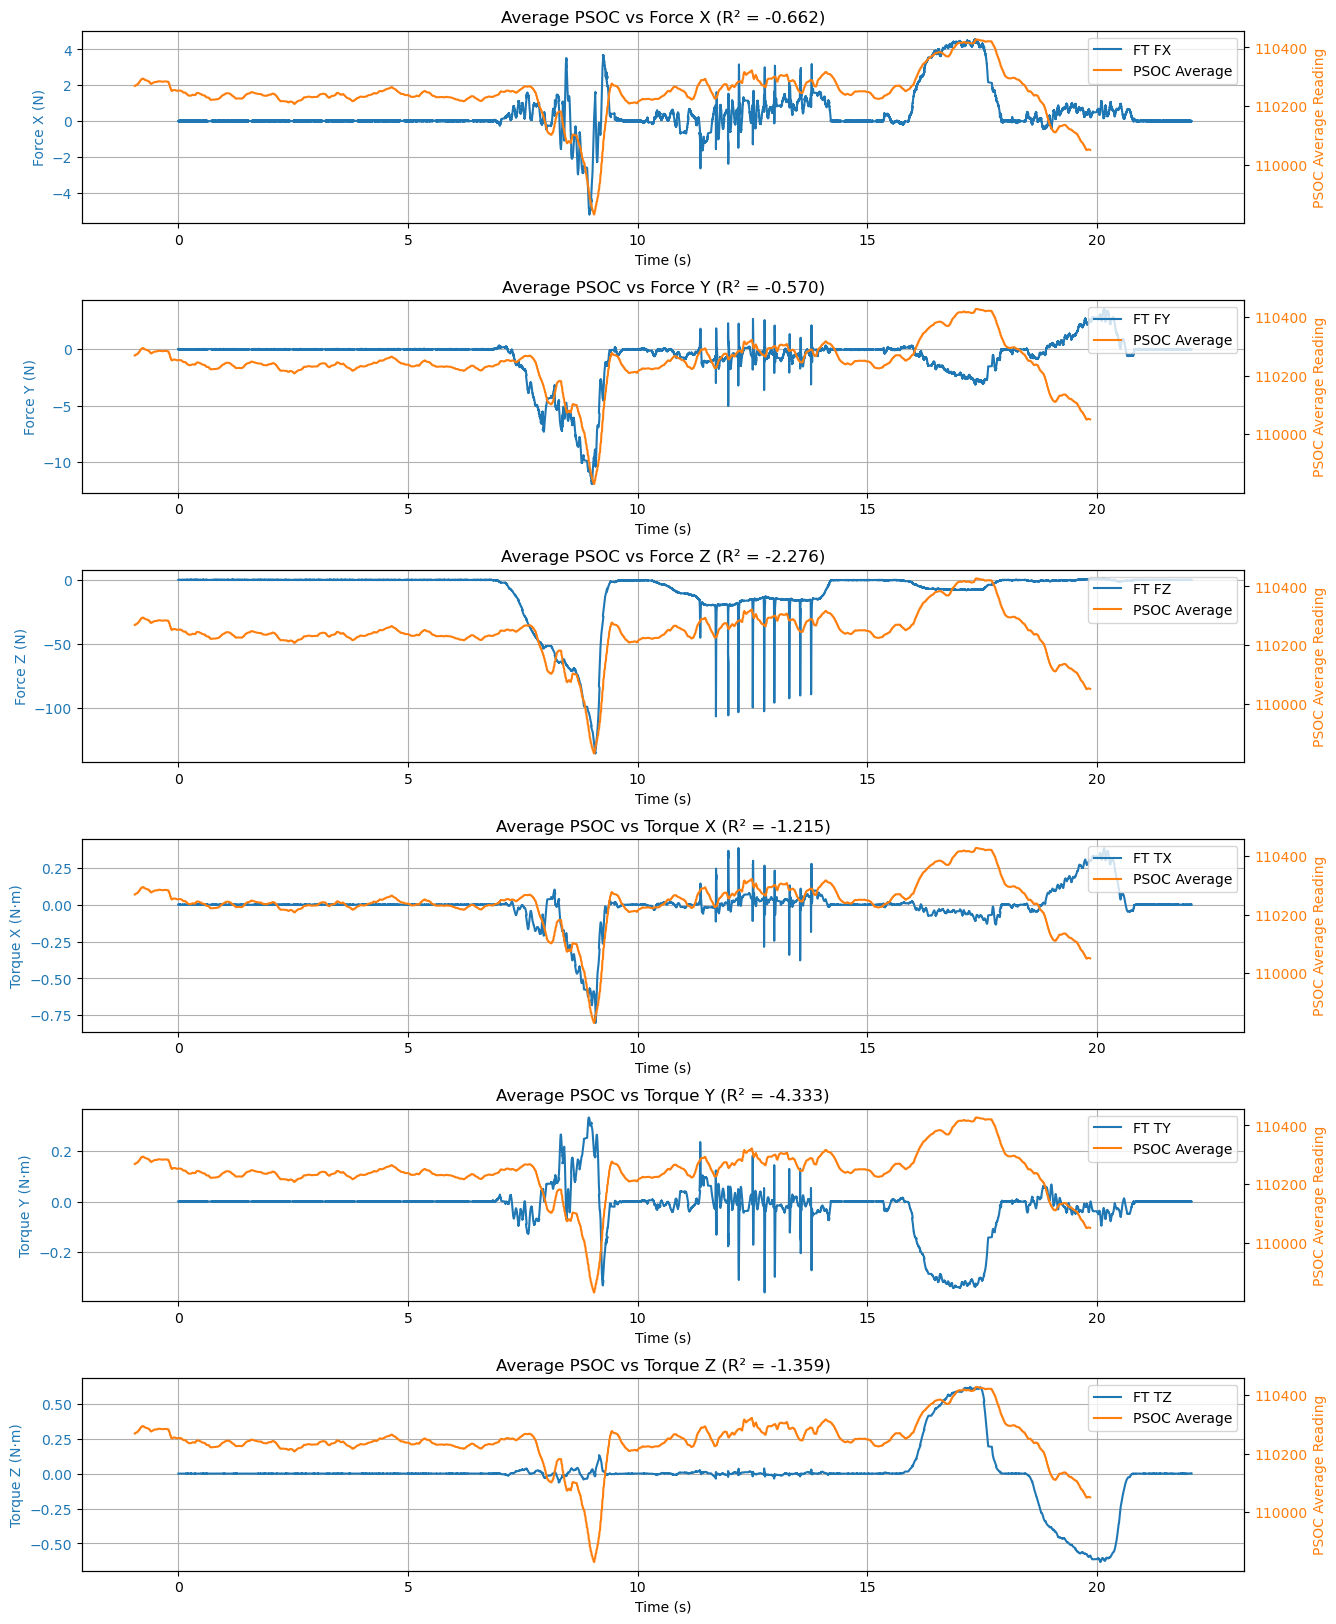

In [112]:
# Calculate average of c1normal through c4normal
avg_normal = psoc_data['ch1'] + psoc_data['ch2'] +psoc_data['ch3'] + psoc_data['ch4']

# Function to calculate R-squared
def calculate_r2(y_true, y_pred):
    residuals = y_true - y_pred
    ss_res = np.sum(residuals ** 2)
    ss_tot = np.sum((y_true - np.mean(y_true)) ** 2)
    return 1 - (ss_res / ss_tot)

# Create figure with subplots for each force/torque measurement
fig = plt.figure(figsize=(15, 20))
gs = fig.add_gridspec(6, 1, hspace=0.4)

# Plot titles and data to plot
plot_data = [
    ('Average PSOC vs Force X', 'fx', 'Force X (N)'),
    ('Average PSOC vs Force Y', 'fy', 'Force Y (N)'),
    ('Average PSOC vs Force Z', 'fz', 'Force Z (N)'),
    ('Average PSOC vs Torque X', 'tx', 'Torque X (N⋅m)'),
    ('Average PSOC vs Torque Y', 'ty', 'Torque Y (N⋅m)'),
    ('Average PSOC vs Torque Z', 'tz', 'Torque Z (N⋅m)')
]

# Create each subplot
for idx, (title, ft_col, ylabel) in enumerate(plot_data):
    ax1 = fig.add_subplot(gs[idx])
    
    # Plot FT sensor data
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel(ylabel, color='tab:blue')
    line1 = ax1.plot(ft_sensor_data['timestamp'], ft_sensor_data[ft_col], 
                     color='tab:blue', label=f'FT {ft_col.upper()}')
    ax1.tick_params(axis='y', labelcolor='tab:blue')
    
    # Create second y-axis and plot PSOC data
    ax2 = ax1.twinx()
    ax2.set_ylabel('PSOC Average Reading', color='tab:orange')
    
    line2 = ax2.plot(psoc_data['timestamp'], avg_normal, 
                     color='tab:orange', label='PSOC Average')
    ax2.tick_params(axis='y', labelcolor='tab:orange')
    
    # Calculate R-squared
    # First interpolate FT sensor data to match PSOC timestamps
    ft_interp = np.interp(psoc_data['timestamp'], 
                         ft_sensor_data['timestamp'], 
                         ft_sensor_data[ft_col])
    
    # Scale both signals to 0-1 range for fair R-squared comparison
    ft_scaled = (ft_interp - ft_interp.min()) / (ft_interp.max() - ft_interp.min())
    psoc_scaled = (avg_normal - avg_normal.min()) / \
                 (avg_normal.max() - avg_normal.min())
    
    r2 = calculate_r2(ft_scaled, psoc_scaled)
    
    # Add title with R-squared and combine legends
    ax1.set_title(f"{title} (R² = {r2:.3f})")
    lines = line1 + line2
    labels = [l.get_label() for l in lines]
    ax1.grid(True)
    ax1.legend(lines, labels, loc='upper right')

plt.tight_layout()  # Adjust layout to prevent label overlap

In [113]:
# Map PSOC data to FT sensor data (6 outputs) by finding closest timestamps
# PSOC inputs: all sensor columns except timestamp
# FT outputs: fx, fy, fz, tx, ty, tz

# For each PSOC timestamp, find the closest FT sensor timestamp
from scipy.spatial import KDTree

# Create a KDTree for efficient nearest neighbor search
ft_timestamps = ft_sensor_data['timestamp'].values.reshape(-1, 1)
psoc_timestamps = psoc_data['timestamp'].values.reshape(-1, 1)

tree = KDTree(ft_timestamps)
distances, indices = tree.query(psoc_timestamps)

# Create aligned dataset
# Extract all PSOC input features except timestamp
X = psoc_data.drop('timestamp', axis=1).values

# Extract the corresponding 6 FT sensor outputs using the matched indices
y = ft_sensor_data.iloc[indices][['fx', 'fy', 'fz', 'tx', 'ty', 'tz']].values

print(f"Created aligned dataset:")
print(f"Input features (PSOC): {X.shape} - {X.shape[1]} sensors x {X.shape[0]} samples")
print(f"Output targets (FT): {y.shape} - 6 measurements x {y.shape[0]} samples")
print(f"\nAverage time difference between matched points: {distances.mean()*1000:.3f} ms")
print(f"Max time difference: {distances.max()*1000:.3f} ms")

# Create a DataFrame for easier viewing
aligned_data = pd.DataFrame(X, columns=psoc_data.drop('timestamp', axis=1).columns)
aligned_data[['fx', 'fy', 'fz', 'tx', 'ty', 'tz']] = y
aligned_data['timestamp'] = psoc_data['timestamp'].values

print("\nFirst few rows of aligned data:")
print(aligned_data.head())
psoc_data

Created aligned dataset:
Input features (PSOC): (7855, 16) - 16 sensors x 7855 samples
Output targets (FT): (7855, 6) - 6 measurements x 7855 samples

Average time difference between matched points: 23.449 ms
Max time difference: 950.000 ms

First few rows of aligned data:
          ch1        ch2         ch3         ch4         ch5         ch6  \
0  25847.6250  28396.500  28320.6875  27703.6250  28077.5625  28029.5000   
1  25847.7500  28396.625  28320.7500  27703.6875  28077.6250  28029.5625   
2  25847.8750  28396.750  28320.8125  27703.7500  28077.6875  28029.6250   
3  25848.0000  28396.875  28320.8750  27703.8125  28077.7500  28029.6875   
4  25848.0625  28397.000  28320.9375  27703.8750  28077.8125  28029.7500   

       ch7        ch8         ch9        ch10  ...        ch14        ch15  \
0  28297.0  28016.750  25848.3125  28397.2500  ...  28031.0000  28297.8750   
1  28297.0  28016.875  25848.3750  28397.3125  ...  28030.9375  28298.0000   
2  28297.0  28017.000  25848.4375  

,timestamp,ch1,ch2,ch3,ch4,ch5,ch6,ch7,ch8,ch9,ch10,ch11,ch12,ch13,ch14,ch15,ch16
0,-0.9500,25847.6250,28396.500,28320.6875,27703.6250,28077.5625,28029.5000,28297.0000,28016.750,25848.3125,28397.2500,28321.1875,27704.8750,28078.0625,28031.0000,28297.8750,28017.7500
1,-0.9485,25847.7500,28396.625,28320.7500,27703.6875,28077.6250,28029.5625,28297.0000,28016.875,25848.3750,28397.3125,28321.2500,27704.8125,28078.1250,28030.9375,28298.0000,28017.8750
2,-0.9471,25847.8750,28396.750,28320.8125,27703.7500,28077.6875,28029.6250,28297.0000,28017.000,25848.4375,28397.3750,28321.3125,27704.7500,28078.1875,28030.8750,28297.9375,28018.0000
3,-0.9362,25848.0000,28396.875,28320.8750,27703.8125,28077.7500,28029.6875,28297.0000,28017.125,25848.5000,28397.4375,28321.3750,27704.6875,28078.2500,28030.8125,28297.8750,28017.9375
4,-0.9347,25848.0625,28397.000,28320.9375,27703.8750,28077.8125,28029.7500,28297.0000,28017.250,25848.5625,28397.5000,28321.4375,27704.6250,28078.3125,28030.7500,28297.8125,28017.8750
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7850,19.8487,25804.6875,28346.000,28247.4375,27653.0000,28084.4375,28051.6250,28304.6875,28022.000,25805.1875,28346.1250,28247.9375,27654.0000,28084.8750,28051.2500,28305.0000,28022.2500
7851,19.8502,25804.7500,28346.000,28247.3750,27652.8750,28084.5000,28051.5625,28304.6250,28022.000,25805.2500,28346.1875,28247.8750,27653.8750,28085.0000,28051.1250,28305.0000,28022.1875
7852,19.8516,25804.8125,28346.000,28247.3125,27652.7500,28084.5625,28051.5000,28304.5625,28022.000,25805.3125,28346.2500,28247.8125,27653.7500,28085.0000,28051.0000,28305.0000,28022.1250
7853,19.8531,25804.8750,28346.000,28247.2500,27652.6250,28084.6250,28051.4375,28304.5000,28022.000,25805.3750,28346.3125,28247.7500,27653.6250,28085.0000,28051.0625,28305.0000,28022.0625


In [114]:
# Second-order polynomial least squares regression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import train_test_split

# Split data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create polynomial features (degree=2 for second order)
poly = PolynomialFeatures(degree=2, include_bias=True)
X_train_poly = poly.fit_transform(X_train)
X_test_poly = poly.transform(X_test)

print(f"Original features: {X_train.shape[1]}")
print(f"Polynomial features (degree 2): {X_train_poly.shape[1]}")
print(f"  (includes linear terms, quadratic terms, and interaction terms)\n")

# Train a separate linear regression model for each output
models = {} 
output_names = ['fx', 'fy', 'fz', 'tx', 'ty', 'tz']

print("Training Results:")
print("=" * 70)
for i, output_name in enumerate(output_names):
    # Train model
    model = LinearRegression()
    model.fit(X_train_poly, y_train[:, i])
    models[output_name] = model
    
    # Make predictions
    y_train_pred = model.predict(X_train_poly)
    y_test_pred = model.predict(X_test_poly)
    
    # Calculate metrics
    train_r2 = r2_score(y_train[:, i], y_train_pred)
    test_r2 = r2_score(y_test[:, i], y_test_pred)
    train_rmse = np.sqrt(mean_squared_error(y_train[:, i], y_train_pred))
    test_rmse = np.sqrt(mean_squared_error(y_test[:, i], y_test_pred))
    
    print(f"{output_name}:")
    print(f"  Train R² = {train_r2:.4f}, RMSE = {train_rmse:.4f}")
    print(f"  Test  R² = {test_r2:.4f}, RMSE = {test_rmse:.4f}")
    print()


print(f"\nModels trained successfully!")
print(f"Use 'models' list to access individual models for each output.")
print(f"Use 'poly' to transform new PSOC data before prediction.")

Original features: 16
Polynomial features (degree 2): 153
  (includes linear terms, quadratic terms, and interaction terms)

Training Results:
fx:
  Train R² = 0.9119, RMSE = 0.3625
  Test  R² = 0.9019, RMSE = 0.3797

fy:
  Train R² = 0.9484, RMSE = 0.4532
  Test  R² = 0.9291, RMSE = 0.4446

fz:
  Train R² = 0.9492, RMSE = 4.7535
  Test  R² = 0.9231, RMSE = 4.9173

tx:
  Train R² = 0.9318, RMSE = 0.0296
  Test  R² = 0.8893, RMSE = 0.0310

ty:
  Train R² = 0.9227, RMSE = 0.0268
  Test  R² = 0.9073, RMSE = 0.0291

tz:
  Train R² = 0.9687, RMSE = 0.0314
  Test  R² = 0.9662, RMSE = 0.0342


Models trained successfully!
Use 'models' list to access individual models for each output.
Use 'poly' to transform new PSOC data before prediction.
fx:
  Train R² = 0.9119, RMSE = 0.3625
  Test  R² = 0.9019, RMSE = 0.3797

fy:
  Train R² = 0.9484, RMSE = 0.4532
  Test  R² = 0.9291, RMSE = 0.4446

fz:
  Train R² = 0.9492, RMSE = 4.7535
  Test  R² = 0.9231, RMSE = 4.9173

tx:
  Train R² = 0.9318, RMSE = 

In [115]:
# Save the trained models to a pickle file
import pickle

with open('models.pkl', 'wb') as f:
    pickle.dump(models, f)

print("Models saved to models.pkl")

Models saved to models.pkl


In [116]:
import pickle
from sklearn.preprocessing import PolynomialFeatures

with open('models.pkl', 'rb') as f:
    models = pickle.load(f)

# Recreate the polynomial features transformer (since it wasn't saved)
poly = PolynomialFeatures(degree=2, include_bias=True)

test_row = np.array(range(16)) + 55000

# Transform the test row
test_poly = poly.fit_transform([test_row])

# Make predictions on the test row
print("Predictions for test_row:")
for name, model in models.items():
    pred = model.predict(test_poly)[0]
    print(f"{name}: {pred:.4f}")

Predictions for test_row:
fx: 463473.5129
fy: 1075476.5192
fz: 15233264.9412
tx: 203925.6483
ty: 10353.0728
tz: -165376.7750
